In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import eqmarl
import functools as ft

2024-11-17 22:55:29.067231: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def observables_func(wires: list[int]):
    return [qml.PauliZ(wires=w) for w in wires]

d_qubits = 4
wires = list(range(d_qubits))
batch_size = 16
n_layers = 3
circuit = eqmarl.circuits.pennylane_circuits.VariationalEncodingCircuit(
    wires=wires,
    d_qubits=d_qubits,
    n_layers=n_layers,
    observables_func=observables_func,
)

encoding_layer_cls=<class 'eqmarl.ops.pennylane_ops.ParameterizedRotationLayer_Rx'>


In [4]:
circuit.shape

((4, 4, 3), (3, 4, 1))

In [5]:
dev = qml.device('default.qubit', wires=len(wires))
qnode = qml.QNode(func=circuit, device=dev)

# Assign random circuit parameters.
shape_var, shape_enc = circuit.shape
weights_var = np.random.uniform(low=0., high=np.pi, size=(batch_size, *shape_var,))
weights_enc = np.random.uniform(low=0., high=np.pi, size=(batch_size, *shape_enc,))

res = qnode(weights_var, weights_enc) # Shape is (n_observables, batch)
res = np.asarray(res).T # Reshape to (batch, n_observables)

In [6]:
res

tensor([[ 0.10187663,  0.32490976,  0.21386782, -0.13369728],
        [-0.08997903,  0.05669892,  0.25127288, -0.09605994],
        [-0.15530088, -0.53537695, -0.04026753,  0.16759376],
        [ 0.55704338,  0.25580871, -0.64595928,  0.60412109],
        [ 0.21597041,  0.0536792 ,  0.23378737,  0.10428458],
        [ 0.11137363,  0.21612195,  0.5082926 , -0.32116912],
        [ 0.11627906, -0.06559753,  0.20586067, -0.15976452],
        [ 0.07612466,  0.14071816, -0.06739376, -0.07686174],
        [ 0.10024622, -0.01934592, -0.19384372, -0.04704886],
        [-0.05713228, -0.48503597,  0.15816941,  0.38793654],
        [ 0.296135  ,  0.28504521,  0.1810979 , -0.15609502],
        [-0.46868112,  0.22095352, -0.18921869, -0.13052125],
        [-0.1187842 ,  0.27860897, -0.06550056,  0.22621281],
        [-0.1372094 ,  0.50753736, -0.37192636,  0.02233897],
        [ 0.05595627,  0.1732262 , -0.36461978, -0.16682552],
        [-0.05367669,  0.45825573,  0.17122672, -0.64745833]], require

(<Figure size 3100x500 with 1 Axes>, <Axes: >)

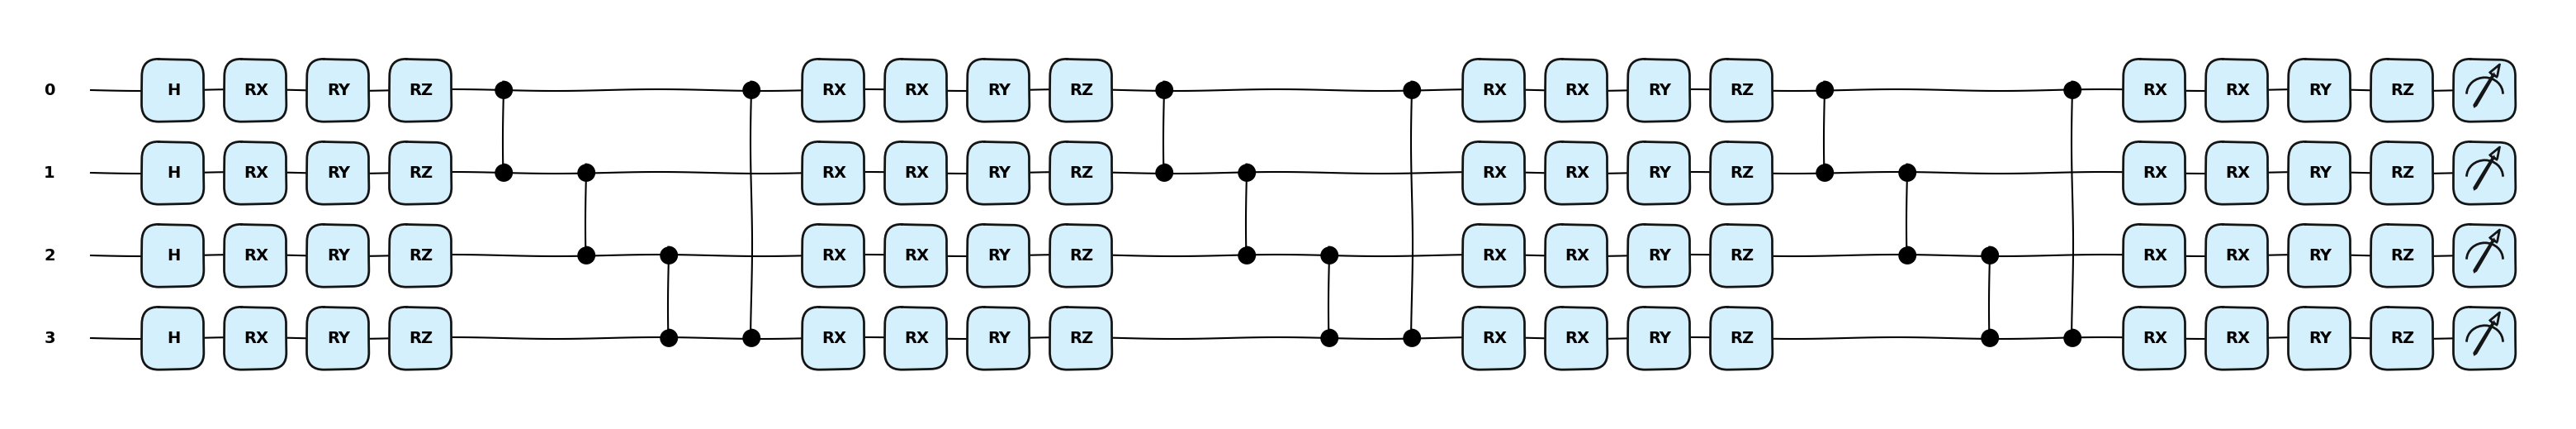

In [7]:
qml.draw_mpl(qnode, wire_order=wires, style="pennylane", decimals=2, expansion_strategy='device')(weights_var, weights_enc)

In [8]:
import json
json.dumps(circuit.weight_shapes)
weight_specs = {
circuit.WeightManifest.WEIGHT_VAR: {},
circuit.WeightManifest.WEIGHT_ENC: {},
}
json.dumps(weight_specs)

"weights_var" == circuit.WeightManifest.WEIGHT_VAR

True

In [9]:
qml.qnn.KerasLayer

pennylane.qnn.keras.KerasLayer

In [10]:
def observables_func(wires: list[int]):
    return [qml.PauliZ(wires=w) for w in wires]

d_qubits = 4
wires = list(range(d_qubits))
batch_size = 16
n_layers = 3


pqc = eqmarl.layers.pennylane_layers.HybridVariationalEncodingPQC(
    wires=wires,
    d_qubits=d_qubits,
    n_layers=n_layers,
    observables_func=observables_func,
    squash_activation='linear',
    trainable_w_enc=False,
    pennylane_device='default.qubit',
)
pqc

# circuit = eqmarl.circuits.pennylane_circuits.VariationalEncodingCircuit(
#     wires=wires,
#     d_qubits=d_qubits,
#     n_layers=n_layers,
#     observables_func=observables_func,
# )

encoding_layer_cls=<class 'eqmarl.ops.pennylane_ops.ParameterizedRotationLayer_Rx'>


In [ ]:
def map_CoinGame2_obs_to_encoded_vector(obs: tf.Tensor) -> tf.Tensor:
    """Reduces last dimension of CoinGame2 observation into single number, where the value is the sum of fractional powers of 2 that represents the column within the game grid.
    
    For example, converts an observation of shape (A,B,C) to (A,B) where the last dimension is reduced using the function $\sum_{i=0}^{C-1} obs[...,i] 2^{-i}$.
    """
    i = -tf.range(obs.shape[-1], dtype=obs.dtype) # Fractional power of 2 that represents the column within the grid.
    return tf.math.reduce_sum(obs * (2**i), axis=-1)


def generate_model_CoinGame2_critic_quantum_central_mdp(
    n_agents: int,
    n_layers: int,
    squash_activation: str = 'arctan', # linear, arctan/atan, tanh
    beta: float = 1.0,
    name: str = None,
    ):
    """Centralized variant of hybrid joint quantum critic for CoinGame.
    """

    # Shape of observables is already known for CoinGame2.
    obs_shape = (4,3,3)

    # Qubit dimension is pre-determined for CoinGame2 environment.
    # Using `4` to match observable dimension.
    d_qubits = 4 * n_agents

    # Create qubit list using qubit dimensions.
    wires = list(range(d_qubits))

    # Observables is joint Pauli product across all qubits.
    # Z1 @ Z2 @ Z3 @ ...
    def observables_func(wires: list[int]):
        return [ft.reduce(lambda x,y: x @ y, [qml.PauliZ(wires=w) for w in wires])]
    
    # Get total number of observables.
    n_observables = len(observables_func(wires=wires))

    # Define quantum layer.
    qlayer = eqmarl.layers.pennylane_layers.HybridVariationalEncodingPQC(
        wires=wires,
        d_qubits=d_qubits,
        n_layers=n_layers,
        observables_func=observables_func,
        squash_activation=squash_activation,
        encoding_layer_cls=eqmarl.ops.pennylane_ops.ParameterizedRotationLayer_RxRyRz,
        trainable_w_enc=True,
        pennylane_device='default.qubit',
    )
    
    print(f"{qlayer.circuit.input_shape=}")
    
    # Raw observations are given as a 1D list, so convert matrix shape into list size.
    input_size = ft.reduce(lambda x, y: x*y, obs_shape)

    model = keras.Sequential([
            keras.Input(shape=(n_agents, input_size), dtype=tf.dtypes.float32, name='input'), # Shape of model input, which should match the observation vector shape.
            keras.Sequential([
                keras.layers.Reshape((n_agents*obs_shape[0], *obs_shape[1:])), # Reshape to matrix grid.
                keras.layers.Lambda(lambda x: map_CoinGame2_obs_to_encoded_vector(x)), # converts (n_agents*4,3,3) into (n_agents*4,3)
                # keras.layers.Reshape(-1),
                # keras.layers.Flatten(),
                ], name="input-preprocess"),
            qlayer,
            keras.Sequential([
                eqmarl.layers.keras_layers.RescaleWeighted(n_observables),
                keras.layers.Lambda(lambda x: x * beta),
                ], name='observables-value')
        ], name=name)
    return model


n_agents = 2
n_layers = 3
squash_activation = 'arctan'
model = generate_model_CoinGame2_critic_quantum_central_mdp(
    n_agents=n_agents,
    n_layers=n_layers,
    squash_activation=squash_activation,
)
model.summary()

qlayer.circuit.input_shape=(8, 3)
[HybridVariationalEncodingPQC_NEW.build] input_shape=TensorShape([None, 8, 3])
[HybridVariationalEncodingPQC_NEW.call] inputs.shape=TensorShape([None, 8, 3])
[HybridVariationalEncodingPQC_NEW.call] angles_enc.shape=TensorShape([None, 3, 8, 3])
[HybridVariationalEncodingPQC_NEW.call] angles_enc.shape=TensorShape([None, 72])
[VariationalEncodingCircuit_NEW.call] inputs.shape=TensorShape([None, 72])
[VariationalEncodingCircuit_NEW.call] inputs.shape=TensorShape([3, 8, 3])
[VariationalEncodingCircuit_NEW.circuit] weights_var.shape=TensorShape([4, 8, 3])
[VariationalEncodingCircuit_NEW.circuit] weights_enc.shape=TensorShape([3, 8, 3])
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function _gcd_import at 0x1042103a0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x1042103a0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x1042103a0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input-preprocess (Sequentia  (None, 8, 3)             0         
 l)                                                              
                                                                 
 HybridVariationalEncodingPQ  (1, 1)                   168       
 C_NEW (HybridVariationalEnc                                     
 

In [12]:
eqmarl.ops.cirq_ops.ParameterizedRotationLayer_Rx.get_shape(8)

(8, 1)

In [13]:
eqmarl.ops.pennylane_ops.ParameterizedRotationLayer_Rx.get_shape(8)

(8, 1)

In [14]:
eqmarl.ops.pennylane_ops.VariationalEncodingParameterizedOperation.get_shape(
    n_layers=n_layers,
    wires=wires,
    )

((4, 4, 3), (3, 4, 1))

In [15]:
model.layers[1].circuit.weight_shapes

{<WeightManifest.WEIGHT_VAR: 'weights_var'>: (4, 8, 3)}

In [16]:
model.layers[1].trainable_variables

[<tf.Variable 'w_enc:0' shape=(3, 8, 3) dtype=float32, numpy=
 array([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]], dtype=float32)>,
 <tf.Variable 'HybridVariationalEncodingPQC_NEW/weights_var:0' shape=(4, 8, 3) dtype=float32, numpy=
 array([[[0.56477344, 1.018036  , 0.8094992 ],
         [2.5172157 , 2.4615872 , 2.2734644 ],
         [2.6067135 , 3.0312443 , 2.7428374 ],
         [1.9885242 , 1.8369248 , 0.75081134],
         [2.6815808 , 0.44109628, 2.3502364 ],
         [1.0020962 , 3.1

In [17]:
model_tfq = eqmarl.models.tfq_models.generate_model_CoinGame2_critic_quantum_central_mdp(
    n_agents=n_agents,
    n_layers=n_layers,
    squash_activation=squash_activation,
)
model_tfq.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input-preprocess (Sequentia  (None, 8, 3)             0         
 l)                                                              
                                                                 
 HybridVariationalEncodingPQ  (None, 1)                168       
 C (HybridVariationalEncodin                                     
 gPQC)                                                           
                                                                 
 observables-value (Sequenti  (None, 1)                1         
 al)                                                             
                                                                 
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________


In [18]:
model_tfq.layers[1].trainable_variables

[<tf.Variable 'w_var:0' shape=(4, 8, 3) dtype=float32, numpy=
 array([[[0.03811133, 2.4187686 , 1.028732  ],
         [0.01121049, 0.3839551 , 2.2359283 ],
         [0.57496756, 0.20977412, 0.8413727 ],
         [2.2116578 , 2.8273616 , 0.73917615],
         [1.3522319 , 2.8756063 , 2.858959  ],
         [0.5780505 , 2.5590994 , 1.9524453 ],
         [2.618387  , 1.9105132 , 1.7676605 ],
         [2.3719537 , 2.0647862 , 2.9025302 ]],
 
        [[1.9736345 , 1.0101597 , 2.8502595 ],
         [2.870166  , 2.3539546 , 0.04094972],
         [1.1968908 , 2.4168646 , 1.8141615 ],
         [1.7603213 , 0.42411762, 1.0286903 ],
         [2.1144257 , 1.3194793 , 2.8356657 ],
         [0.5895415 , 0.7341735 , 3.035584  ],
         [2.4806414 , 2.6536453 , 3.0123491 ],
         [1.082826  , 0.91954845, 1.412808  ]],
 
        [[2.4500015 , 0.27860364, 0.3484874 ],
         [1.4638559 , 2.1137633 , 2.1068892 ],
         [2.957578  , 0.62593085, 0.50654215],
         [2.459059  , 0.80342734, 0.547

In [40]:
def generate_model_CoinGame2_critic_quantum_partite_mdp(
    n_agents: int,
    n_layers: int,
    squash_activation: str = 'arctan', # linear, arctan/atan, tanh
    beta: float = 1.0,
    name: str = None,
    input_entanglement: bool = True, # Flag to enable input entanglement (defaults to True).
    input_entanglement_type: bool = 'phi+', # ['phi+', 'phi-', 'psi+', 'psi-']
    ):
    """eQMARL variant of hybrid joint quantum critic for CoinGame.
    """

    # Shape of observables is already known for CoinGame2.
    obs_shape = (4,3,3)

    # Qubit dimension is pre-determined for CoinGame2 environment.
    # Using `4` to match observable dimension.
    d_qubits = 4

    # Create qubit list using qubit dimensions.
    wires = list(range(n_agents * d_qubits))

    # Observables is joint Pauli product across all qubits.
    def observables_func(wires):
        return [ft.reduce(lambda x,y: x@y, [qml.PauliZ(wires=w) for w in wires])]

    # Get total number of observables.
    n_observables = len(observables_func(wires=wires))

    # Define quantum layer.
    # qlayer = HybridPartiteVariationalEncodingPQC(
    #     qubits=qubits, 
    #     n_parts=n_agents,
    #     d_qubits=d_qubits,
    #     n_layers=n_layers,
    #     observables=observables,
    #     squash_activation=squash_activation,
    #     encoding_layer_cls=ParameterizedRotationLayer_RxRyRz,
    #     input_entanglement=input_entanglement,
    #     input_entanglement_type=input_entanglement_type,
    #     )
    qlayer = eqmarl.layers.pennylane_layers.HybridPartiteVariationalEncodingPQC(
        wires=wires,
        n_parts=n_agents,
        d_qubits=d_qubits,
        n_layers=n_layers,
        observables_func=observables_func,
        squash_activation=squash_activation,
        encoding_layer_cls=eqmarl.ops.pennylane_ops.ParameterizedRotationLayer_RxRyRz,
        input_entanglement=input_entanglement,
        input_entanglement_type=input_entanglement_type,
        trainable_w_enc=True,
        # pennylane_device='default.qubit.tf',
        pennylane_device='lightning.qubit',
    )
    
    # Raw observations are given as a 1D list, so convert matrix shape into list size.
    input_size = ft.reduce(lambda x, y: x*y, obs_shape)

    model = keras.Sequential([
            keras.Input(shape=(n_agents, input_size), dtype=tf.dtypes.float32, name='input'), # Shape of model input, which should match the observation vector shape.
            keras.Sequential([
                keras.layers.Reshape((n_agents, *obs_shape)), # Reshape to matrix grid.
                keras.layers.Lambda(lambda x: map_CoinGame2_obs_to_encoded_vector(x)), # converts (n_agents,4,3,3) into (n_agents,4,3)
                ], name="input-preprocess"),
            qlayer,
            keras.Sequential([
                eqmarl.layers.keras_layers.RescaleWeighted(n_observables),
                keras.layers.Lambda(lambda x: x * beta),
                ], name='observables-value')
        ], name=name)
    return model


n_agents = 2
n_layers = 3
squash_activation = 'arctan'
model = generate_model_CoinGame2_critic_quantum_partite_mdp(
    n_agents=n_agents,
    n_layers=n_layers,
    squash_activation=squash_activation,
)
model.summary()

[HybridPartiteVariationalEncodingPQC] input_shape=TensorShape([None, 2, 4, 3])
[HybridPartiteVariationalEncodingPQC.call] self.w_enc.shape=TensorShape([2, 3, 4, 3])
[HybridPartiteVariationalEncodingPQC.call] inputs.shape=TensorShape([None, 2, 4, 3])
[HybridPartiteVariationalEncodingPQC.call] angles_enc.shape=TensorShape([None, 2, 3, 4, 3])
[HybridPartiteVariationalEncodingPQC.call] angles_enc.shape=TensorShape([None, 72])
[PartiteVariationalEncodingCircuit.call] inputs.shape=TensorShape([None, 72])
[PartiteVariationalEncodingCircuit.call] shape_enc=(2, 3, 4, 3)
[PartiteVariationalEncodingCircuit.call] inputs.shape=TensorShape([None, 2, 3, 4, 3])
[PartiteVariationalEncodingCircuit.circuit] weights_var.shape=TensorShape([2, 4, 4, 3])
[PartiteVariationalEncodingCircuit.circuit] weights_enc.shape=TensorShape([None, 2, 3, 4, 3])


ValueError: Exception encountered when calling layer "HybridPartiteVariationalEncodingPQC" (type HybridPartiteVariationalEncodingPQC).

in user code:

    File "/Users/derieux/graduate/research/quantum/eqmarl/eqmarl/layers/pennylane_layers.py", line 365, in call  *
        return self.qlayer(angles_enc)
    File "/usr/local/Caskroom/miniforge/base/envs/eqmarl/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "keras_layer" (type KerasLayer).
    
    in user code:
    
        File "/usr/local/Caskroom/miniforge/base/envs/eqmarl/lib/python3.9/site-packages/pennylane/qnn/keras.py", line 383, in call  *
            results = self._evaluate_qnode(inputs)
        File "/usr/local/Caskroom/miniforge/base/envs/eqmarl/lib/python3.9/site-packages/pennylane/qnn/keras.py", line 410, in _evaluate_qnode  *
            res = [tf.reshape(r, (tf.shape(x)[0], tf.reduce_prod(r.shape[1:]))) for r in res]
    
        ValueError: Cannot convert a partially known TensorShape <unknown> to a Tensor.
    
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 72), dtype=float32)


Call arguments received:
  • inputs=tf.Tensor(shape=(None, 2, 4, 3), dtype=float32)

In [34]:
n_agents = 2
n_layers = 3
squash_activation = 'arctan'
model_central = generate_model_CoinGame2_critic_quantum_central_mdp(
    n_agents=n_agents,
    n_layers=n_layers,
    squash_activation=squash_activation,
)
model_partite = generate_model_CoinGame2_critic_quantum_partite_mdp(
    n_agents=n_agents,
    n_layers=n_layers,
    squash_activation=squash_activation,
)

qlayer.circuit.input_shape=(8, 3)
[HybridVariationalEncodingPQC_NEW.build] input_shape=TensorShape([None, 8, 3])
[HybridVariationalEncodingPQC_NEW.call] inputs.shape=TensorShape([None, 8, 3])
[HybridVariationalEncodingPQC_NEW.call] angles_enc.shape=TensorShape([None, 3, 8, 3])
[HybridVariationalEncodingPQC_NEW.call] angles_enc.shape=TensorShape([None, 72])
[VariationalEncodingCircuit_NEW.call] inputs.shape=TensorShape([None, 72])
[PartiteVariationalEncodingCircuit.call] shape_enc=(3, 8, 3)
[VariationalEncodingCircuit_NEW.call] inputs.shape=TensorShape([None, 3, 8, 3])
[VariationalEncodingCircuit_NEW.circuit] weights_var.shape=TensorShape([4, 8, 3])
[VariationalEncodingCircuit_NEW.circuit] weights_enc.shape=TensorShape([None, 3, 8, 3])
[HybridPartiteVariationalEncodingPQC] input_shape=TensorShape([None, 2, 4, 3])
[HybridPartiteVariationalEncodingPQC.call] self.w_enc.shape=TensorShape([2, 3, 4, 3])
[HybridPartiteVariationalEncodingPQC.call] inputs.shape=TensorShape([None, 2, 4, 3])
[Hybr

[VariationalEncodingCircuit_NEW.call] inputs.shape=(16, 3, 8, 3)
[PartiteVariationalEncodingCircuit.call] shape_enc=(3, 8, 3)
[VariationalEncodingCircuit_NEW.call] inputs.shape=TensorShape([16, 3, 8, 3])
[VariationalEncodingCircuit_NEW.circuit] weights_var.shape=(16, 4, 8, 3)
[VariationalEncodingCircuit_NEW.circuit] weights_enc.shape=TensorShape([16, 3, 8, 3])


/usr/local/Caskroom/miniforge/base/envs/eqmarl/lib/python3.9/site-packages/pennylane/math/utils.py:227: UserWarning: Contains tensors of types {'tensorflow', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


(<Figure size 4900x900 with 1 Axes>, <Axes: >)

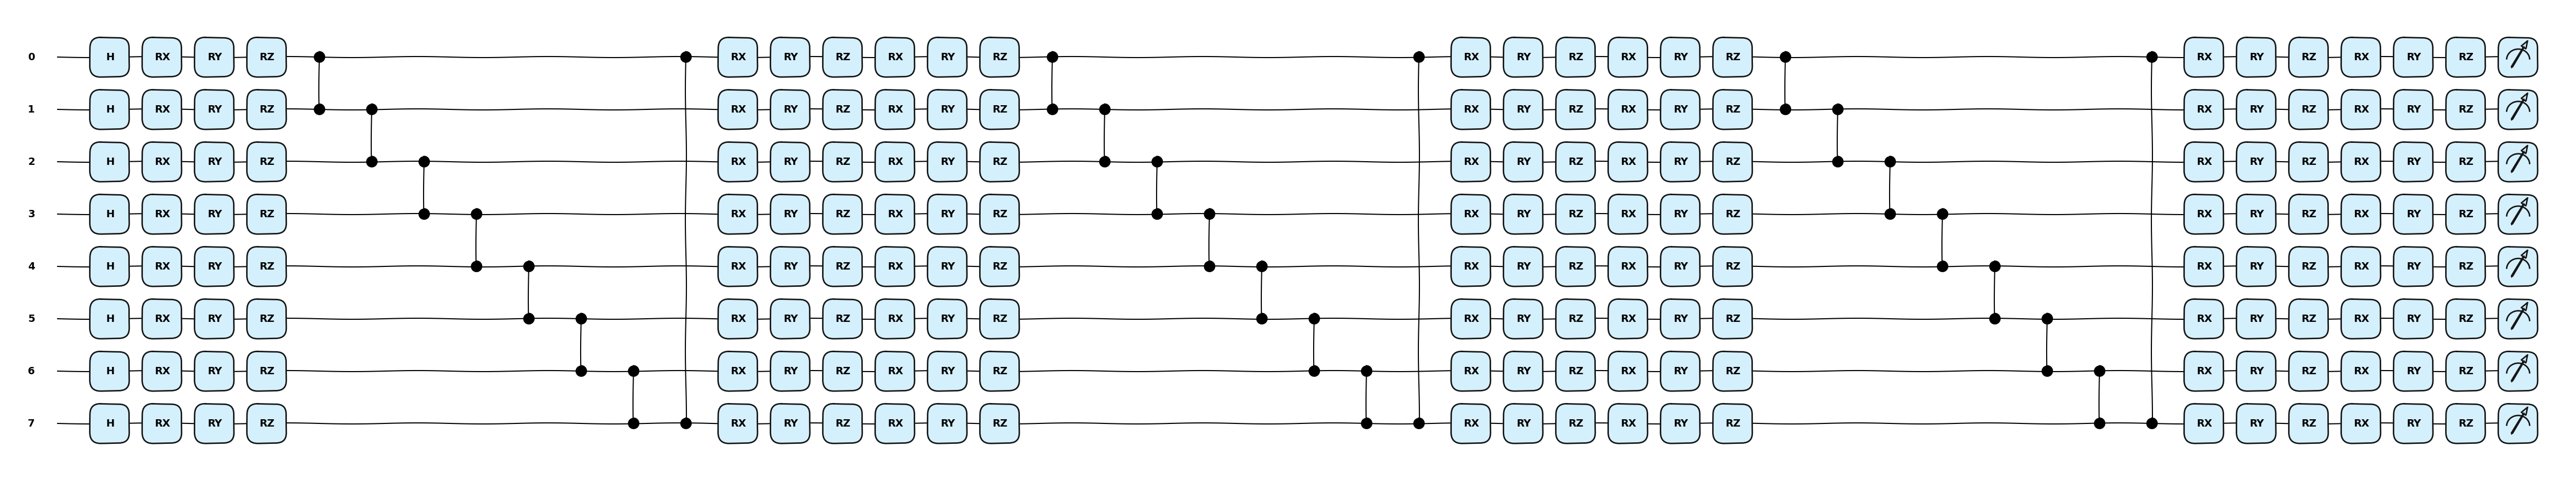

In [35]:
# Assign random circuit parameters.
shape_var, shape_enc = model_central.layers[1].circuit.shape
weights_var = np.random.uniform(low=0., high=np.pi, size=(batch_size, *shape_var,))
weights_enc = np.random.uniform(low=0., high=np.pi, size=(batch_size, *shape_enc,))

qml.draw_mpl(model_central.layers[1].qnode, wire_order=model_central.layers[1].wires, style="pennylane", decimals=2, expansion_strategy='device')(weights_var, weights_enc)

[PartiteVariationalEncodingCircuit.call] inputs.shape=(16, 2, 3, 4, 3)
[PartiteVariationalEncodingCircuit.call] shape_enc=(2, 3, 4, 3)
[PartiteVariationalEncodingCircuit.call] inputs.shape=TensorShape([16, 2, 3, 4, 3])
[PartiteVariationalEncodingCircuit.circuit] weights_var.shape=(16, 2, 4, 4, 3)
[PartiteVariationalEncodingCircuit.circuit] weights_enc.shape=TensorShape([16, 2, 3, 4, 3])


/usr/local/Caskroom/miniforge/base/envs/eqmarl/lib/python3.9/site-packages/pennylane/math/utils.py:227: UserWarning: Contains tensors of types {'tensorflow', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


(<Figure size 4400x900 with 1 Axes>, <Axes: >)

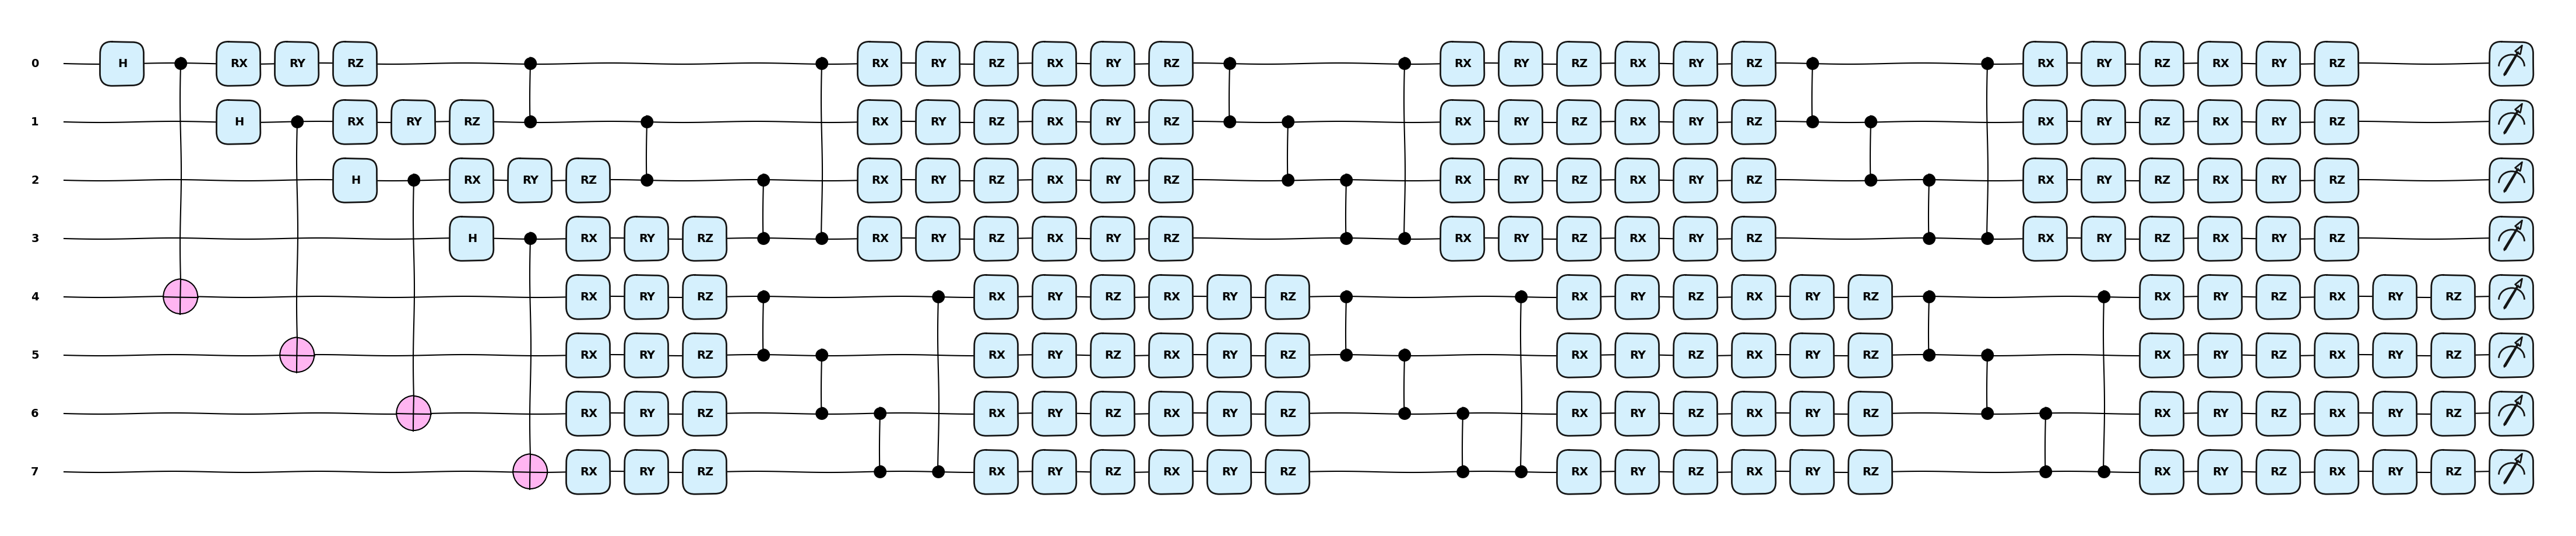

In [36]:
# Assign random circuit parameters.
shape_var, shape_enc = model_partite.layers[1].circuit.shape
weights_var = np.random.uniform(low=0., high=np.pi, size=(batch_size, *shape_var,))
weights_enc = np.random.uniform(low=0., high=np.pi, size=(batch_size, *shape_enc,))

qml.draw_mpl(model_partite.layers[1].qnode, wire_order=model_partite.layers[1].wires, style="pennylane", decimals=2, expansion_strategy='device')(weights_var, weights_enc)